# Logistic Regression

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Read Data

In [3]:
# imputed train and validation set
df_train = pd.read_csv("train.csv")
print(len(df_train.columns), len(df_train))
df_valid = pd.read_csv("validation.csv")
print(len(df_valid.columns), len(df_valid))
df_train.tail(3)

40 353653
40 44207


,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadAngina,...,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HadHeartAttack
353650,IA,Male,Excellent,0,0,0-1y,Yes,7,1 to 5,No,...,81.65,27.37,No,No,Yes,Yes,Yes not Tdap,No,No,No
353651,PR,Male,Good,0,0,0-1y,No,8,More than 6,No,...,74.84,25.84,No,No,No,No,No,No,No,No
353652,OR,Male,Very good,0,0,0-1y,Yes,2,NaN,No,...,58.97,24.56,No,Yes,Yes,No,Yes Tdap,No,No,No


### Doublecheck on missing values

After data pre-processing, the 'None' values in the RemovedTeeth column is read by pandas as NA. This feature was again transformed to reflect the correct data (0).

In [4]:
missing_cols = df_train.isnull().any()
df = pd.DataFrame({
    "column": missing_cols.index,
    "bool": missing_cols.values
})
columns_with_missing = df.loc[df['bool'], 'column'].tolist()

print(columns_with_missing)
df_train[columns_with_missing][0:5]

['RemovedTeeth']


,RemovedTeeth
0,NaN
1,1 to 5
2,NaN
3,1 to 5
4,1 to 5


Fill N/A with proper vlaue

In [5]:
df_train = df_train.fillna('0')
df_valid = df_valid.fillna('0')

df_train[columns_with_missing][0:5]

,RemovedTeeth
0,0
1,1 to 5
2,0
3,1 to 5
4,1 to 5


### Drop column 'State'

In [6]:
df_train = df_train.drop(['State'], axis='columns')
df_valid = df_valid.drop(['State'], axis='columns')

df_train.head(3)

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadAngina,HadStroke,...,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HadHeartAttack
0,Female,Very good,8,2,0-1y,Yes,7,0,No,No,...,76.20,28.84,Yes,Yes,Yes,No,Yes Tdap,No,"Yes, tested positive at home",No
1,Female,Very good,0,0,0-1y,Yes,6,1 to 5,No,No,...,88.00,31.10,Yes,No,Yes,Yes,Yes but not sure,No,No,No
2,Male,Very good,2,7,1-2y,Yes,7,0,No,No,...,74.84,25.09,Yes,No,Yes,Yes,No,No,No,No


### Get dummies

In [8]:
# Transform categorical variables to dummy variables
df_train_dummy = pd.get_dummies(df_train, drop_first=True, dtype='int')
df_valid_dummy = pd.get_dummies(df_valid, drop_first=True, dtype='int')

df_train_dummy.tail(3)

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI,Sex_Male,GeneralHealth_Fair,GeneralHealth_Good,GeneralHealth_Poor,...,HIVTesting_Yes,FluVaxLast12_Yes,PneumoVaxEver_Yes,TetanusLast10Tdap_Yes Tdap,TetanusLast10Tdap_Yes but not sure,TetanusLast10Tdap_Yes not Tdap,HighRiskLastYear_Yes,CovidPos_Yes,"CovidPos_Yes, tested positive at home",HadHeartAttack_Yes
353650,0,0,7,1.73,81.65,27.37,1,0,0,0,...,0,1,1,0,0,1,0,0,0,0
353651,0,0,8,1.70,74.84,25.84,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
353652,0,0,2,1.55,58.97,24.56,1,0,0,0,...,1,1,0,1,0,0,0,0,0,0


### Split X, y
We use 'HadHeartAttack_Yes' column as the response variable y, ans the rest are the features.

In [9]:
X_train = df_train_dummy.drop('HadHeartAttack_Yes', axis='columns')
y_train = pd.Series(df_train_dummy.HadHeartAttack_Yes.values)

X_valid = df_valid_dummy.drop('HadHeartAttack_Yes', axis='columns')
y_valid = pd.Series(df_valid_dummy.HadHeartAttack_Yes.values)

print('X_train Shape:   ', X_train.shape)
print('y_train Shape:   ', y_train.shape)

print('\nX_valid Shape: ', X_valid.shape)
print('y_valid Shape:   ', y_valid.shape)

X_train Shape:    (353653, 68)
y_train Shape:    (353653,)

X_valid Shape:  (44207, 68)
y_valid Shape:    (44207,)


## Logistic Regression Model

In [10]:
# Logistic Regression
model_lr = LogisticRegression(penalty=None, max_iter=10000)
history = model_lr.fit(X_train, y_train)

### Prediction on validation set

In [11]:
# Performance on test set
y_pred = model_lr.predict(X_valid)
y_prob = model_lr.predict_proba(X_valid)[:,1]

### Evaluation

#### ROC and AUC score
**Receiver Operating Characteristics (ROC) Curve**
plots the true positive rate (TPR) vs the false positive rate (FPR) at different classification thresholds.
<br>**Area Under Curve (AUC) Curve**
represents the probability with which our model can distinguish between the two classes present in our target

ROC-AUC Score: 0.8879894963993155


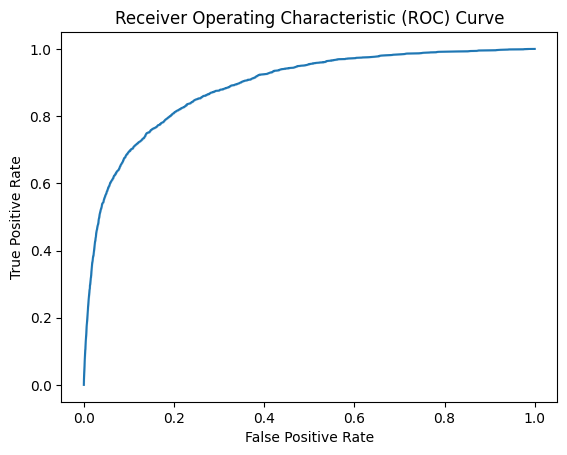

In [12]:
# ROC curve
fpr, tpr, _ = roc_curve(y_valid, y_prob)
ax=sns.lineplot(x=fpr,y=tpr)

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Calculate the AUC score
auc_score = roc_auc_score(y_valid, y_prob)
print("ROC-AUC Score:", auc_score)

#### PRC and AUC score
**Precision-Recall (PR) Curve**
is simply a graph with Precision values on the y-axis and Recall values on the x-axis.

PRC-AUC score is 0.4255094958795482


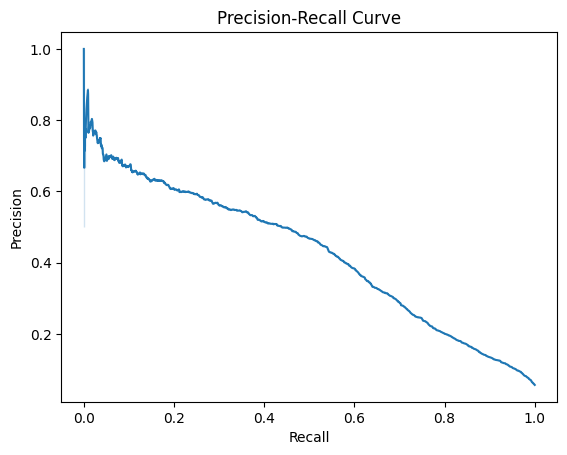

In [13]:
# PRC for all-variable classifier
precision, recall, thresholds = precision_recall_curve(y_valid, y_prob, pos_label=1)
ax=sns.lineplot(x=recall,y=precision)

plt.title("Precision-Recall Curve")
plt.ylabel("Precision")
plt.xlabel("Recall")

# Calculate the AUC score
auc_score = auc(recall, precision)
print("PRC-AUC score is", auc_score)

#### Confusion Matrix

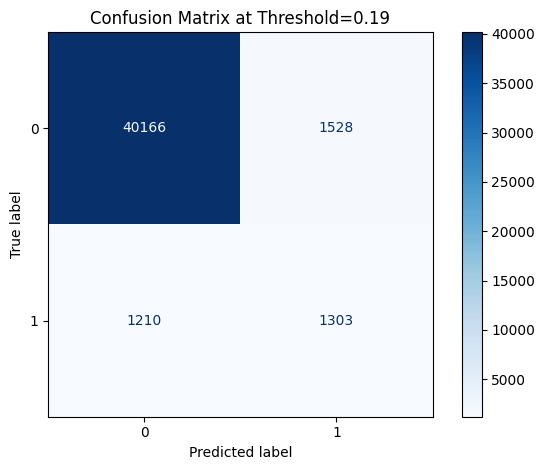

In [14]:
# f1_scores under various thresholds, find the best
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

# Generate predictions based on best threshold
y_pred_best = (y_prob >= best_threshold).astype(int)

# Display Confusion Matrix
cm = confusion_matrix(y_valid, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", ax=plt.gca(), colorbar=True, values_format='')
plt.title(f"Confusion Matrix at Threshold={best_threshold:.2f}")

plt.tight_layout()
plt.show()

#### Accuracy, Precision, Recall and F1 score

In [15]:
accuracy, precision, recall = accuracy_score(y_valid, y_pred_best), precision_score(y_valid, y_pred_best), recall_score(y_valid, y_pred_best)
f1 = f1_score(y_valid, y_pred_best)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9380641074942883
Precision: 0.4602613917343695
Recall: 0.5185037803422204
F1 Score: 0.4876497005988024


## Hyperparameter Optimization

Aside from the standard Logistic Regression model, we also looked into the Penalized Logistic Regression using the Elastic Net model.
This has 2 hyperparameters: 1) alpha (or lambda), which dictates the weight of ridge penalty, and (1 - alpha) for lasso penalty, and 2) C, which controls the regularization strength.

### RandomSearchCV - ElasticNet

In [36]:
# Comebien training and validation set
X_combined = pd.concat([X_train, X_valid], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_valid], axis=0).reset_index(drop=True)

# Define test_fold: -1 for training samples, 0 for validation samples
test_fold = np.full(len(X_train), -1)  # Mark training samples
test_fold = np.append(test_fold, np.zeros(len(X_valid)))  # Mark validation samples

# Create PredefinedSplit
custom_split = PredefinedSplit(test_fold=test_fold)

In [37]:
# Create the model pipeline
pipeline = Pipeline(
    [("Scaling", StandardScaler()),  # Scale features
     ("logisticregression", LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=1000)
        )]
)

In [38]:
scoring_metrics = {
    'f1': make_scorer(f1_score)
    #'recall': make_scorer(recall_score),
    #'precision': make_scorer(precision_score)
}

In [39]:
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength C
    'logisticregression__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],  # Elastic Net mix ratio
}

random_search = RandomizedSearchCV(
    estimator = pipeline,
    param_distributions = param_grid,
    n_iter = 66,  # Number of random combinations to test
    scoring = scoring_metrics,  # Use multiple metrics
    refit = 'f1',  # Use F1-score to determine the best hyperparameters
    cv = custom_split,  # Use the predefined train-validation split
    random_state = 456,
    verbose= 2
)

In [19]:
# Fit the search on the training set
random_search.fit(X_combined, y_combined)

# Retrieve the best parameters and scores
print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"Best F1-Score: {random_search.best_score_}")

Fitting 1 folds for each of 66 candidates, totalling 66 fits
[CV] END logisticregression__C=0.001, logisticregression__l1_ratio=0; total time=   5.3s
[CV] END logisticregression__C=0.001, logisticregression__l1_ratio=0.1; total time=   6.6s
[CV] END logisticregression__C=0.001, logisticregression__l1_ratio=0.2; total time=   7.3s
[CV] END logisticregression__C=0.001, logisticregression__l1_ratio=0.3; total time=   6.3s
[CV] END logisticregression__C=0.001, logisticregression__l1_ratio=0.4; total time=   5.2s
[CV] END logisticregression__C=0.001, logisticregression__l1_ratio=0.5; total time=   5.6s
[CV] END logisticregression__C=0.001, logisticregression__l1_ratio=0.6; total time=   5.7s
[CV] END logisticregression__C=0.001, logisticregression__l1_ratio=0.7; total time=   5.2s
[CV] END logisticregression__C=0.001, logisticregression__l1_ratio=0.8; total time=   5.9s
[CV] END logisticregression__C=0.001, logisticregression__l1_ratio=0.9; total time=   6.0s
[CV] END logisticregression__C=

### GridSearchCV on L2-regularization
The best l1_ratio is 0, hence we conclude L2-regularization is sufficient. <br>
Since the solver used in the Elastic Net implementation is "saga", we did another hyperparameter tuning for alpha (or lambda) using the standard solver for l2-penalty. <br>

Best Hyperparameters: {'logistic_regression__C': 0.01, 'logistic_regression__penalty': 'l2'}
Best Cross-validation Score: -0.3626373626373626


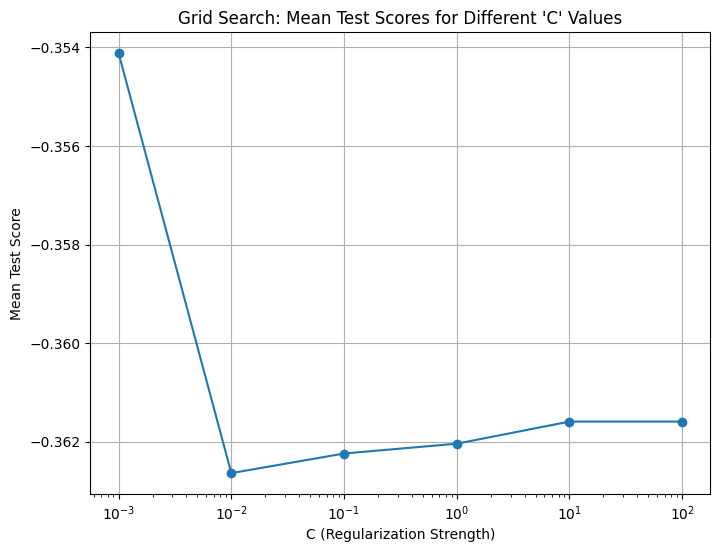

In [40]:
pipe_logistic = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(
        max_iter=1000))
])

coefs = [0.001, 0.01, 0.1, 1, 10, 100]  # Regularization strength C

# GridSearchCV
param_grid = {
    'logistic_regression__C': coefs,  # Regularization strength
    'logistic_regression__penalty': ['l2']  # Type of regularization
}
grid_search = GridSearchCV(estimator=pipe_logistic, 
                           param_grid=param_grid, 
                           cv=custom_split, 
                           scoring='f1')

grid_search.fit(X_combined, y_combined)
scores = -grid_search.cv_results_['mean_test_score']

# plot mse with log(lambda)
plt.figure(figsize=(8, 6))
plt.xscale("log")
plt.grid(True)

plt.title("Grid Search: Mean Test Scores for Different 'C' Values")
plt.xlabel("C (Regularization Strength)") # log(C)
plt.ylabel("Mean Test Score")
plt.plot(coefs, scores, marker='o')

# Output the best parameters
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-validation Score:", -grid_search.best_score_)


### Performance of the best model on validation set
We achieved higher ROC-AUC and PRC-AUC scores.

In [41]:
# Get the best model
best_model_lr = grid_search.best_estimator_

# Performance on test set
y_pred = best_model_lr.predict(X_valid)
y_prob = best_model_lr.predict_proba(X_valid)[:,1]

# AUC scores under best parameter
roc_auc = roc_auc_score(y_valid, y_prob)
print("ROC-AUC Score:", roc_auc)

precision, recall, thresholds = precision_recall_curve(y_valid, y_prob, pos_label=1)
prc_auc = auc(recall, precision)
print("PRC-AUC score is", prc_auc)

ROC-AUC Score: 0.8891805304411113
PRC-AUC score is 0.4266338693075572


### Optimize Decision Threshold

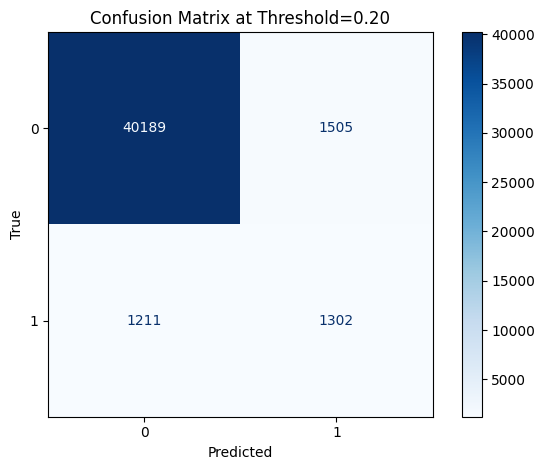

In [42]:
# f1_scores under various thresholds, find the best
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

# Generate predictions based on best threshold
y_pred_best = (y_prob >= best_threshold).astype(int)

# Display Confusion Matrix
cm = confusion_matrix(y_valid, y_pred_best)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues", ax=plt.gca(), colorbar=True, values_format='')
plt.title(f"Confusion Matrix at Threshold={best_threshold:.2f}")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


## Final Validation Performance

In [71]:
accuracy, precision, recall = accuracy_score(y_valid, y_pred_best), precision_score(y_valid, y_pred_best), recall_score(y_valid, y_pred_best)
f1 = f1_score(y_valid, y_pred_best)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9385617662361164
Precision: 0.46384039900249374
Recall: 0.5181058495821727
F1 Score: 0.48947368421052634


## Other supporting visualiation

### Coefficients and P-Values of all featuers

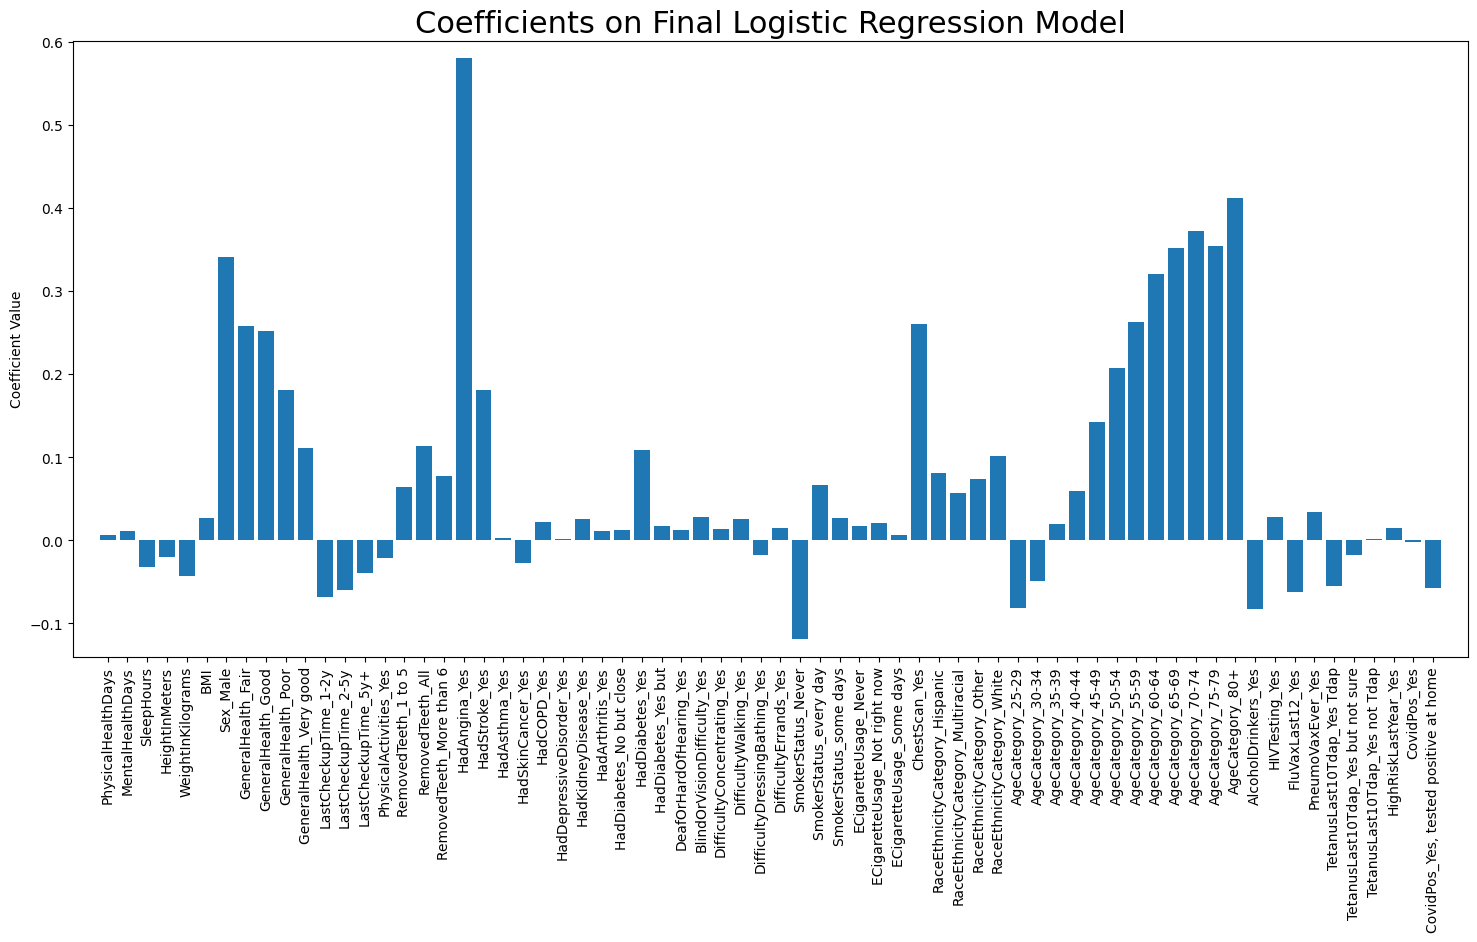

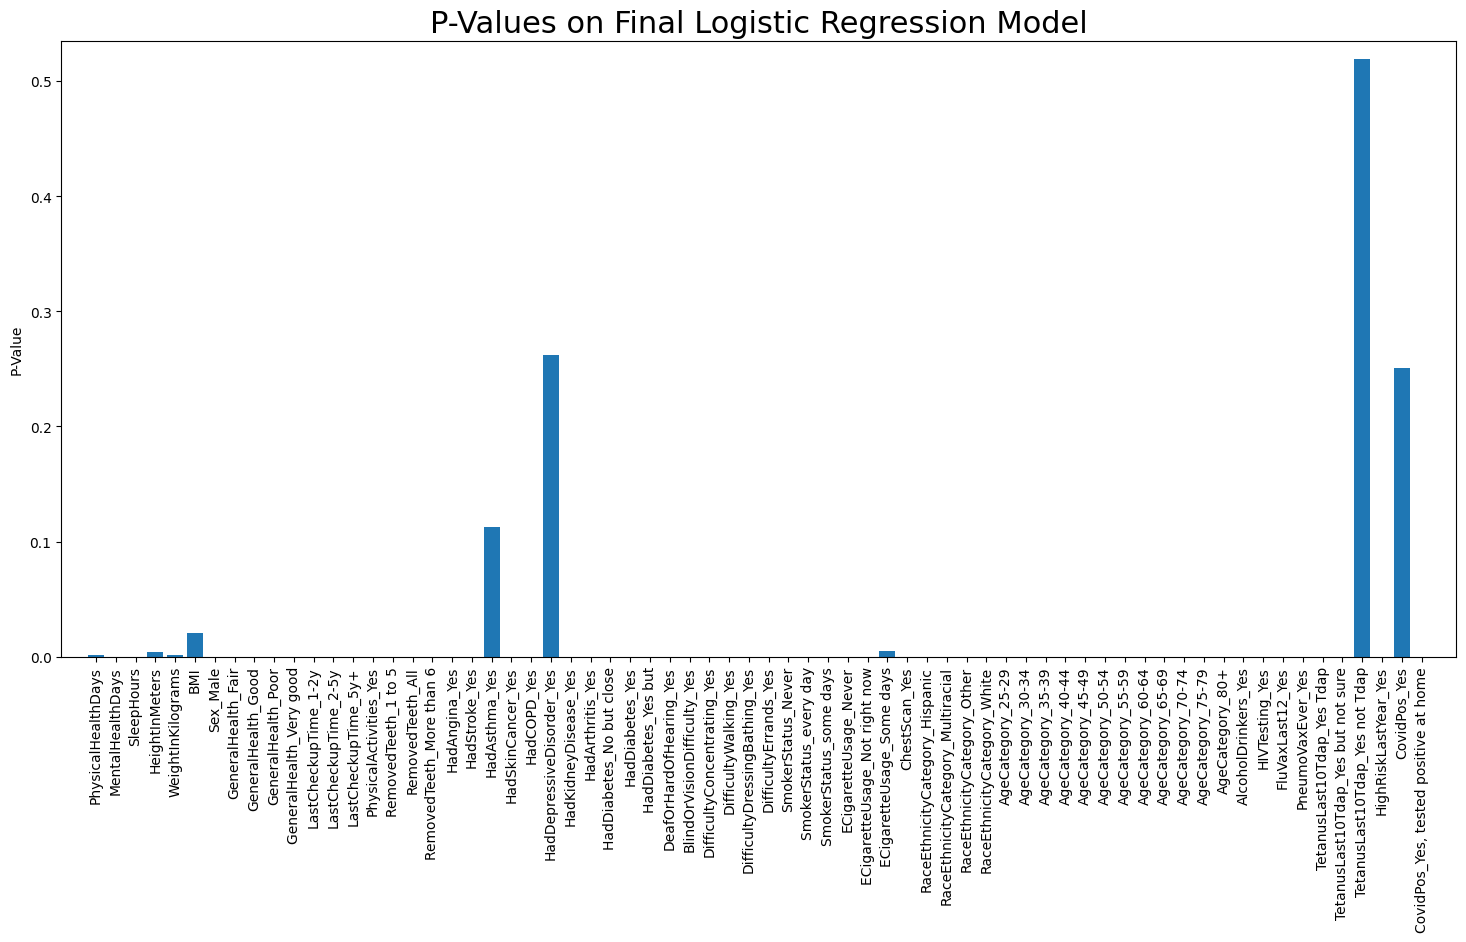

In [72]:
# Extract logistic regression model from the pipeline
log_reg_model = best_model_lr.named_steps['logistic_regression']

# Coefficients and intercept
coefficients = log_reg_model.coef_[0]
intercept = log_reg_model.intercept_

# Get Hessian matrix
scaler = best_model_lr.named_steps['scaler']
X_train_scaled = scaler.transform(X_train)
inverse_hessian = np.linalg.inv(np.dot(X_train_scaled.T, X_train_scaled))

# Calculate p-values
se = np.sqrt(np.diagonal(inverse_hessian))
z_values = coefficients / se
p_values = 2 * (1 - norm.cdf(np.abs(z_values)))

# Plot the coefficients
plt.figure(figsize=(18, 8))
plt.bar(X_train.columns, coefficients)
plt.title("Coefficients on Final Logistic Regression Model", fontsize=22)
plt.ylabel("Coefficient Value")
plt.xticks(rotation=90)
plt.margins(x=0.02,y=0.03)
plt.show()

# Plot p-values
plt.figure(figsize=(18, 8))
plt.bar(X_train.columns, p_values)
plt.title("P-Values on Final Logistic Regression Model", fontsize=22)
plt.ylabel("P-Value")
plt.xticks(rotation=90)
plt.margins(x=0.02,y=0.03)
plt.show()


### Top-10 Features by Coefficients 

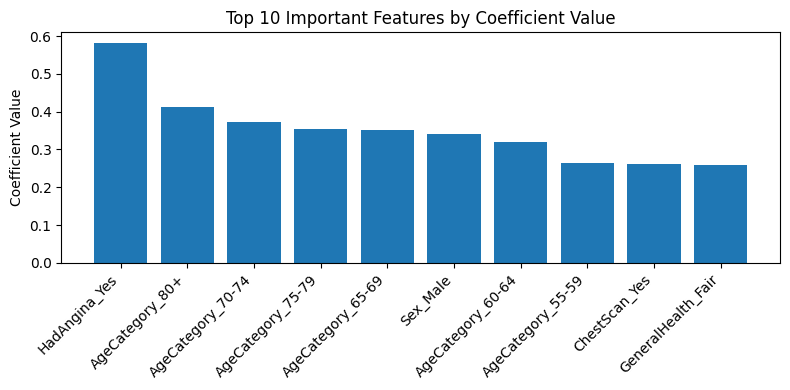

In [73]:
# Get the absolute values of coefficients and sort them
coefficients_abs = np.abs(coefficients)
top_indices = np.argsort(coefficients_abs)[-10:]  # Indices of the top 10 coefficients
top_indices = np.flip(top_indices) # Ascending reversed to Descending

# Select the top 10 features and their coefficients
top_features = X_train.columns[top_indices]
top_coefficients = coefficients[top_indices]

# Plot the top 10 coefficients
plt.figure(figsize=(8, 4))
plt.bar(top_features, top_coefficients)
plt.title("Top 10 Important Features by Coefficient Value")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
